## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

## Load Dataset

In [2]:
# Define chunk size
chunksize = 5_000_000
ratings_chunks = []
movies = pd.read_csv("movies.csv")  # movies dataset is usually small, can load fully

# Read ratings in chunks and merge each chunk with movies
for chunk in pd.read_csv("ratings.csv", chunksize=chunksize):
    merged_chunk = chunk.merge(movies, on="movieId", how="left")
    ratings_chunks.append(merged_chunk)

# Concatenate all chunks
df = pd.concat(ratings_chunks, ignore_index=True)

print("Dataset shape after merging:", df.shape)
df.head()

Dataset shape after merging: (27753444, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,307,3.5,1256677221,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1,1,481,3.5,1256677456,Kalifornia (1993),Drama|Thriller
2,1,1091,1.5,1256677471,Weekend at Bernie's (1989),Comedy
3,1,1257,4.5,1256677460,Better Off Dead... (1985),Comedy|Romance
4,1,1449,4.5,1256677264,Waiting for Guffman (1996),Comedy


In [3]:
print(df.info())
print(df.describe())
print(df.shape)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.2+ GB
None
             userId       movieId        rating     timestamp
count  2.775344e+07  2.775344e+07  2.775344e+07  2.775344e+07
mean   1.419420e+05  1.848800e+04  3.530445e+00  1.193122e+09
std    8.170740e+04  3.510263e+04  1.066353e+00  2.160482e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    7.117600e+04  1.097000e+03  3.000000e+00  9.986053e+08
50%    1.420220e+05  2.716000e+03  3.500000e+00  1.174256e+09
75%    2.124590e+05  7.150000e+03  4.000000e+00  1.422744e+09
max    2.832280e+05  1.938860e+05  5.000000e+00  1.537945e+09
(27753444, 6)
userId       0
movieId      0
rating       0
timestamp 

## Data Visualization

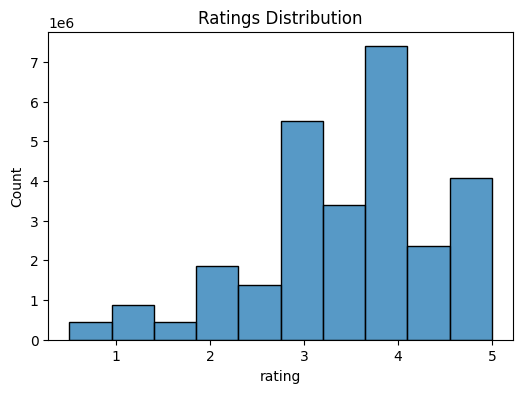

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(df['rating'], bins=10)
plt.title("Ratings Distribution")
plt.show()

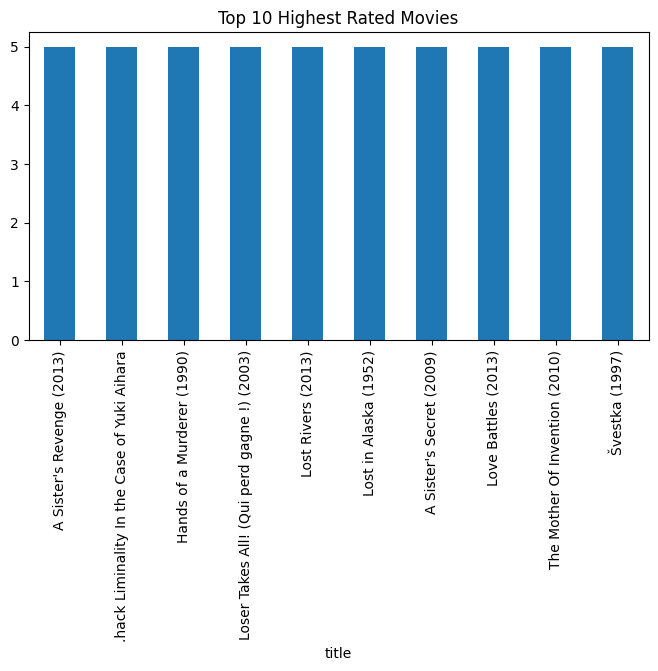

In [5]:
# Top 10 highest rated movies
top_movies = df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
top_movies.plot(kind='bar', figsize=(8,4), title="Top 10 Highest Rated Movies")
plt.show()

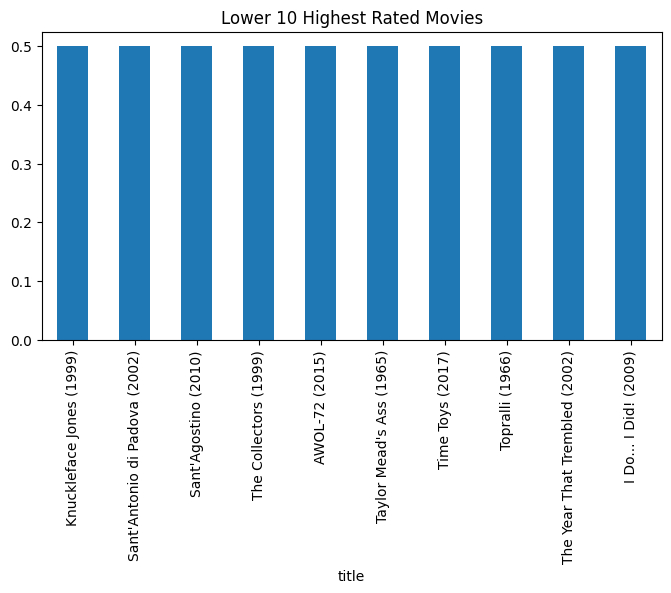

In [6]:
# lower 10 highest rated movies
top_movies = df.groupby('title')['rating'].mean().sort_values(ascending=False).tail(10)
top_movies.plot(kind='bar', figsize=(8,4), title="Lower 10 Highest Rated Movies")
plt.show()

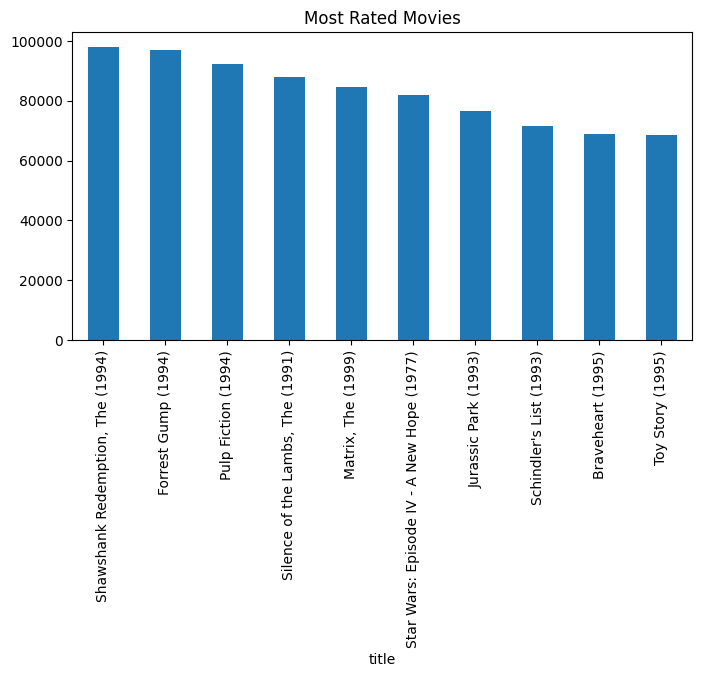

In [7]:
# Most rated movies
most_rated = df['title'].value_counts().head(10)
most_rated.plot(kind='bar', figsize=(8,4), title="Most Rated Movies")
plt.show()

## Encode Categorial Variables

In [8]:
# Encode categorical variables
user_enc = LabelEncoder()
movie_enc = LabelEncoder()
genre_enc = LabelEncoder()

df['user_enc'] = user_enc.fit_transform(df['userId'])
df['movie_enc'] = movie_enc.fit_transform(df['movieId'])
df['genre_enc'] = genre_enc.fit_transform(df['genres'])

## Collaborative Filtering (CF)

In [9]:
# Take a sample for CF (1M rows)
sample_df = df.sample(n=1_000_000, random_state=42)
print("Sample shape for CF:", sample_df.shape)

# Re-encode user and movie IDs **only for the sample**
user_enc_sample = LabelEncoder()
movie_enc_sample = LabelEncoder()

sample_df['user_enc'] = user_enc_sample.fit_transform(sample_df['userId'])
sample_df['movie_enc'] = movie_enc_sample.fit_transform(sample_df['movieId'])

n_users = sample_df['user_enc'].nunique()
n_movies = sample_df['movie_enc'].nunique()

# Create sparse user–movie matrix (memory safe)
R = csr_matrix((sample_df['rating'],
                (sample_df['user_enc'], sample_df['movie_enc'])),
               shape=(n_users, n_movies))

# Compute user similarity
user_sim = cosine_similarity(R, dense_output=False)

Sample shape for CF: (1000000, 9)


In [10]:
# Test CF prediction
def predict_cf(user, movie, k=10):
    """Predict rating for user & movie using user-based CF"""
    if movie >= R.shape[1] or user >= R.shape[0]:
        return np.nan
    
    ratings = R[:, movie].toarray().flatten()
    sims = user_sim[user].toarray().flatten()
    
    mask = ratings > 0
    if mask.sum() == 0:
        return np.nan
    
    ratings = ratings[mask]
    sims = sims[mask]
    
    top_k_idx = np.argsort(sims)[-k:]
    pred = np.dot(ratings[top_k_idx], sims[top_k_idx]) / (sims[top_k_idx].sum() + 1e-9)
    return pred

# Example prediction
u = sample_df['user_enc'].iloc[0]
m = sample_df['movie_enc'].iloc[0]
print("CF Predicted Rating:", predict_cf(u, m))

CF Predicted Rating: 3.856568381778043


In [11]:
# Create test set from the sample
test_sample = sample_df.sample(n=1000, random_state=42)  # small test set for speed

# Predict ratings
cf_preds = []
cf_true = []

for row in test_sample.itertuples():
    pred = predict_cf(row.user_enc, row.movie_enc)
    if not np.isnan(pred):
        cf_preds.append(pred)
        cf_true.append(row.rating)

# Convert to numpy arrays
cf_preds = np.array(cf_preds)
cf_true = np.array(cf_true)

# Compute RMSE & MAE
rmse_cf = np.sqrt(np.mean((cf_true - cf_preds)**2))
mae_cf = np.mean(np.abs(cf_true - cf_preds))

print("CF RMSE (sample):", rmse_cf)
print("CF MAE (sample):", mae_cf)

CF RMSE (sample): 0.6959977459287188
CF MAE (sample): 0.5303290636075845


## Regression Model

In [12]:
# Take a random sample (e.g., 1 million rows) for memory efficiency
sample_df = df.sample(n=1_000_000, random_state=42)
print("Sample shape for regression:", sample_df.shape)

# Features & target from the sample
X = sample_df[['user_enc', 'movie_enc', 'genre_enc']]
y = sample_df['rating']

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Regression RMSE (sample):", rmse)
print("Regression MAE (sample):", mae)

Sample shape for regression: (1000000, 9)
Regression RMSE (sample): 1.126676494496091
Regression MAE (sample): 0.877367


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regression Model Evaluation on Sample:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)

Regression Model Evaluation on Sample:
RMSE: 1.126676494496091
MAE: 0.877367
R² Score: -0.11613297236579911


In [14]:
results = pd.DataFrame({
    "Model": ["Collaborative Filtering (CF sample)", "Regression (sample)"],
    "RMSE": [rmse_cf, rmse],
    "MAE": [mae_cf, mae],
    "R²": [np.nan, r2]  # CF does not have R²
})
results

,Model,RMSE,MAE,R²
0,Collaborative Filtering (CF sample),0.695998,0.530329,NaN
1,Regression (sample),1.126676,0.877367,-0.116133


## Example Prediction

In [16]:
import warnings
warnings.filterwarnings("ignore")

def predict_movie(userId, movieId, genre):
    # Transform to encoded integers
    u = user_enc.transform([userId])[0]
    m = movie_enc.transform([movieId])[0]
    g = genre_enc.transform([genre])[0]
    
    # Predict using the regression model
    return rf.predict([[u, m, g]])[0]

# Example prediction
user_id = 10
movie_id = 50
genre_name = "Comedy"
pred_rating = predict_movie(user_id, movie_id, genre_name)
print(f"Predicted rating for User {user_id} on Movie {movie_id} ({genre_name}): {pred_rating:.2f}")

Predicted rating for User 10 on Movie 50 (Comedy): 2.35
